In [13]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import time
from random import choice
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from moviepy.editor import VideoFileClip
%matplotlib inline

# 1. Explore the Data

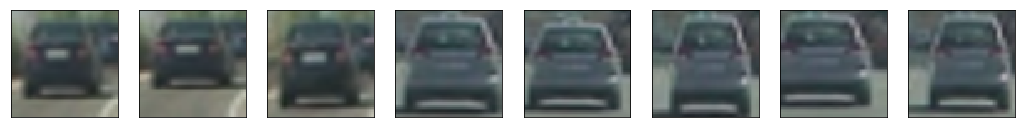

Total vehicle: 8792
Image size: (64, 64, 3)


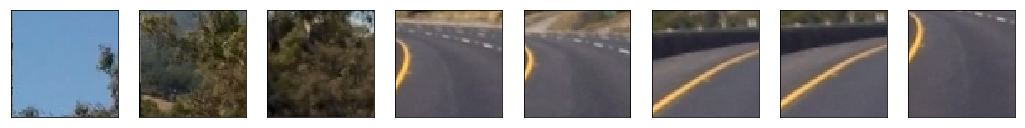

Total non-vehicle: 9666
Image size: (64, 64, 3)


In [2]:
# Grab all the training images
vehicles = glob.glob('training_data/vehicles/*/*.png')
non_vehicles = glob.glob('training_data/non-vehicles/*/*.png')

# Plot some sample vehicle images
img_cnt = 8
f, ax = plt.subplots(1, img_cnt, figsize = (18, 16))
for i in range(0, img_cnt):
    sample = mpimg.imread(vehicles[i])
    ax[i].imshow(sample)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()
print('Total vehicle: %d' %len(vehicles))
img_size = sample.shape
print('Image size: {}'.format(img_size))

# Plot some sample non-vehicle images
f, ax = plt.subplots(1, img_cnt, figsize = (18, 16))
for i in range(0, img_cnt):
    sample = mpimg.imread(non_vehicles[i])
    ax[i].imshow(sample)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()
print('Total non-vehicle: %d' %len(non_vehicles))
img_size = sample.shape
print('Image size: {}'.format(img_size))

In [3]:
# Get the X training tdata
X = np.zeros( (len(vehicles) + len(non_vehicles), *img_size), dtype=np.float32)
i = 0
for img in vehicles:
    X[i,:,:,:] = mpimg.imread(img)
    i += 1
for img in non_vehicles:    
    X[i,:,:,:] = mpimg.imread(img)
    i += 1
    
print(X.shape)

(18458, 64, 64, 3)


In [4]:
# Get the y training data
y = np.hstack((np.ones(len(vehicles)), np.zeros(len(non_vehicles)))).astype(np.float32)
print(y.shape)

(18458,)


### Save the raw data as a pickle

In [5]:
raw_pickle = {}
raw_pickle['X'] = X
raw_pickle['y'] = y
with open('training_data/raw_pickle.p','wb') as output_file:
    pickle.dump(raw_pickle, output_file)

### Load the raw data pickle

In [6]:
with open('training_data/raw_pickle.p', 'rb') as input_file:
    p = pickle.load(input_file)
X, y = p['X'], p['y']

# 2. Feature Selection

In [7]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [8]:
def plot_hog_examples(img, orient = 9, pix_per_cell = 8, cell_per_block = 2):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    _, ax = plt.subplots(1, 6, figsize = (18, 6))
    ax[0].imshow(img)
    ax[0].set_title('original')
    
    _, gray_hog = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis = True)
    ax[1].imshow(gray_hog)
    ax[1].set_title('gray hog')
    
    _, h_hog = get_hog_features(hls[:,:,0], orient, pix_per_cell, cell_per_block, vis = True)
    ax[2].imshow(h_hog)
    ax[2].set_title('h hog')
    
    _, l_hog = get_hog_features(hls[:,:,1], orient, pix_per_cell, cell_per_block, vis = True)
    ax[3].imshow(l_hog)
    ax[3].set_title('l hog')
    
    _, s_hog = get_hog_features(hls[:,:,2], orient, pix_per_cell, cell_per_block, vis = True)
    ax[4].imshow(s_hog)
    ax[4].set_title('s hog')
    
    _, v_hog = get_hog_features(hsv[:,:,2], orient, pix_per_cell, cell_per_block, vis = True)
    ax[5].imshow(v_hog)
    ax[5].set_title('v hog')
    
    plt.show()

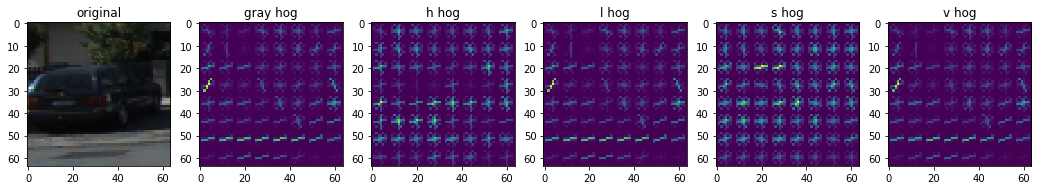

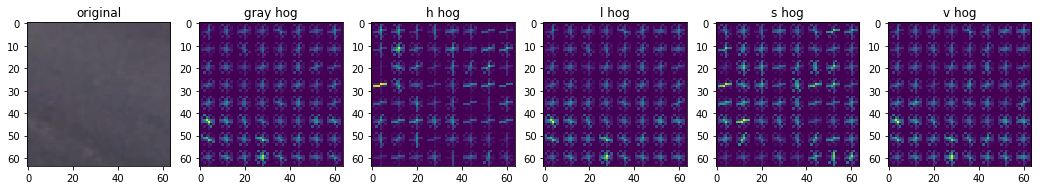

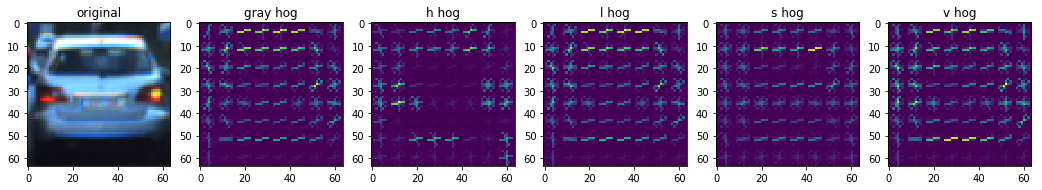

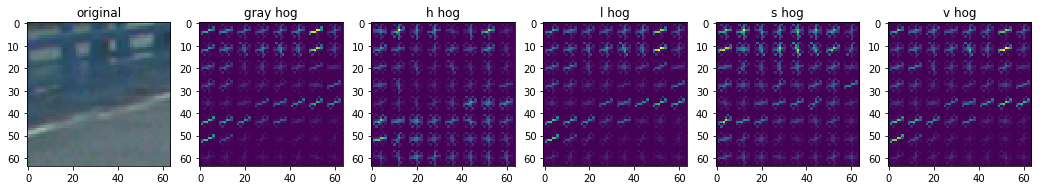

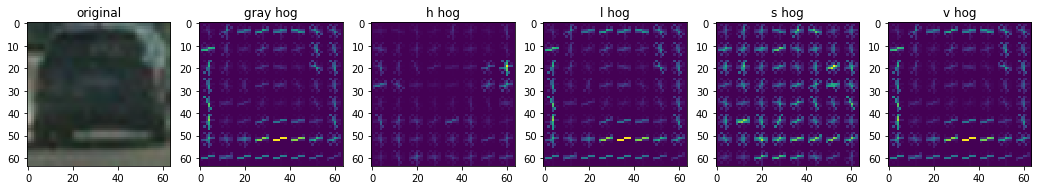

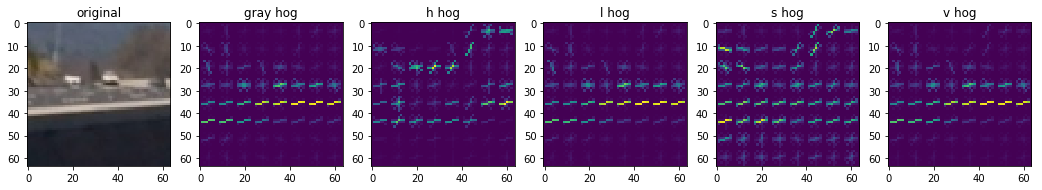

In [9]:
# Plot different HOGs from random images
for _ in range(0, 3):
    plot_hog_examples(mpimg.imread(choice(vehicles)))
    plot_hog_examples(mpimg.imread(choice(non_vehicles)))

In [12]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    cnt = imgs.shape[0]
    # Iterate through the list of images
    for i in range(0, cnt):
        # Read in each one by one
        image = imgs[i,:,:,:]
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [14]:
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t1 = time.time()
features = extract_features(X, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
t2 = time.time()
print(round(t2 - t1, 2), 'Seconds to extract features...' )

81.02 Seconds to extract features...


In [15]:
X = np.array(features).astype(np.float32)
X_scaler = StandardScaler().fit(features)
scaled_X = X_scaler.transform(features)
print(scaled_X.shape, y.shape)

(18458, 5292) (18458,)


# 3. Train the ata

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=12345)
svc = LinearSVC()
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t1, 2), 'Seconds to train SVC...' )
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

21.51 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9832
My SVC predicts:  [ 1.  1.  1.  1.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  0.  1.  1.  1.  0.]


# 4. Sliding Window